/var/folders/nf/0f78fmr95hz6c9cwnjjzzdlr0000gp/T/ipykernel_36785/1131652473.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rbd = px.resample("M").last().index



Sharpe-ranked comparison:
                 Sharpe   CAGR  MaxDD    Vol  Sortino
Strategy          1.526  0.193 -0.168  0.121    1.924
Benchmark (SPY)   0.814  0.150 -0.337  0.196    0.994


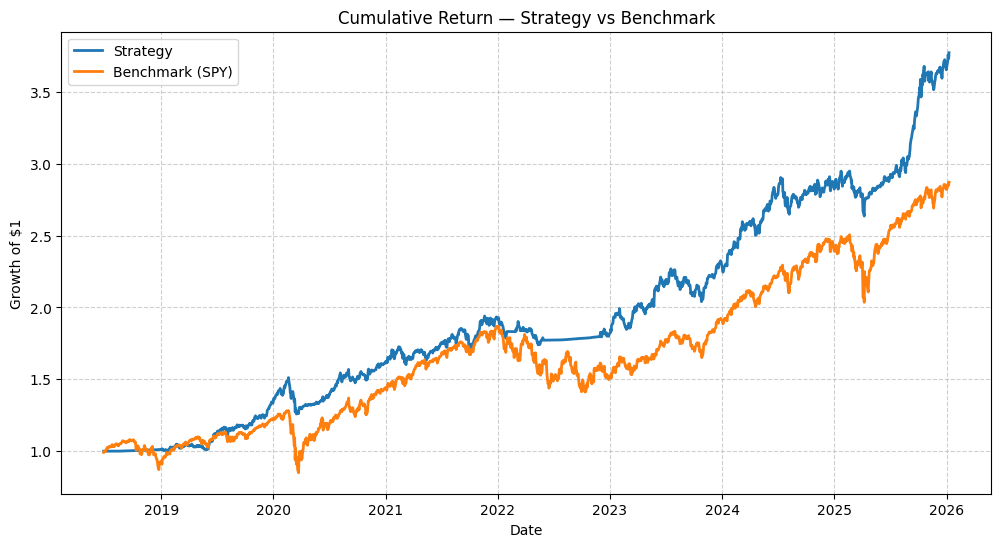

In [8]:

# pip install yfinance pandas numpy matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.display import display

# =========================
# Settings
# =========================
START = "2018-01-01"

# set to true to adjust volatility to market regime
USE_DYNAMIC_VT = False

# --- Equity candidates that replace SPY ---
EQUITY_CANDS = [
    "QLD", "QQQ"
]  # <- add more if you want

# Dual Momentum settings (relative momentum lookback)
MOM_LKBK = 84
MOM_SKIP = 21
REQ_POS_MOM = True

# Optional per-ETF momentum lookback overrides (only for tickers in EQUITY_CANDS)
MOM_LKBK_BY_TICKER = {}

# Other risky sleeves (kept as-is)
OTHER_SLEEVES = [
    "SMH", 
    "HYMB", 
    "GLDM"
]

# Defensive sleeve (cash only)
CASH = "BIL"

REB = "W"        # you currently rebalance weekly in code (see rbd below)
COST_BPS = 5     # one-way trading cost (simple)

# Fixed MA windows
DEFAULT_MA = 150
MA_FIXED = {
    "SMH": 200,
    "HYMB": 50,
    "GLDM": 110,
}

# Risk-parity & smoothing
VOL_LKBK = 60
EMA_ALPHA = 0.30
VT_TARGET = 0.12
VT_LKBK = 40
GROSS_CAP = 1.5

# ---- Benchmark ETF ----
BENCH_TKR = "SPY"



# =========================
# Data
# =========================
ALL_STRAT_TICKERS = sorted(set(EQUITY_CANDS + OTHER_SLEEVES + [CASH, BENCH_TKR]))

px_all = yf.download(
    ALL_STRAT_TICKERS, start=START, auto_adjust=True, progress=False
)["Close"]

px_all = px_all.dropna(axis=1, how="all")

present = [t for t in EQUITY_CANDS + OTHER_SLEEVES + [CASH] if t in px_all.columns]
px = px_all[present].copy()

px = px.ffill().dropna()
rets = px.pct_change().dropna()

# Benchmark (align to strategy timeline later)
if BENCH_TKR in px_all.columns:
    bench_px = px_all[BENCH_TKR].dropna()
    bench_rets = bench_px.pct_change().dropna()
else:
    bench_rets = None

# Rebalance dates on the *price calendar*
# NOTE: your original code used monthly ("M") despite REB="W".
# Keeping your existing behavior: monthly rebalance.
rbd = px.resample("M").last().index
rbd = rbd.intersection(px.index)

# =========================
# Helpers
# =========================
def kpi(ser: pd.Series):
    s = ser.dropna()
    if s.empty:
        return dict(CAGR=np.nan, Sharpe=np.nan, Vol=np.nan, Sortino=np.nan, MaxDD=np.nan)
    cum = (1 + s).cumprod()
    yrs = (s.index[-1] - s.index[0]).days / 365.25
    cagr = cum.iloc[-1] ** (1 / yrs) - 1 if yrs > 0 else np.nan
    vol = s.std() * np.sqrt(252)
    sharpe = (s.mean() * 252) / vol if vol > 0 else np.nan
    mdd = (cum / cum.cummax() - 1).min()
    dvol = s[s < 0].std() * np.sqrt(252) if (s < 0).sum() > 1 else np.nan
    sortino = (s.mean() * 252) / dvol if (isinstance(dvol, float) and dvol > 0) else np.nan
    return dict(CAGR=cagr, Sharpe=sharpe, Vol=vol, Sortino=sortino, MaxDD=mdd)

def get_ma_window(ticker: str) -> int:
    """MA window for a ticker (no inverse logic)."""
    return int(MA_FIXED.get(ticker, DEFAULT_MA))

def ma_signal(series: pd.Series, win: int) -> pd.Series:
    ma = series.rolling(win).mean()
    return (series > ma).astype(int)

def momentum_score(series: pd.Series, asof: pd.Timestamp, lookback: int, skip: int) -> float:
    """
    Dual momentum-style score:
      score = price(asof - skip) / price(asof - lookback - skip) - 1
    """
    s = series.loc[:asof].dropna()
    if len(s) < (lookback + skip + 5):
        return np.nan
    end = s.iloc[-1 - skip] if skip > 0 else s.iloc[-1]
    start = s.iloc[-1 - skip - lookback]
    if start <= 0 or end <= 0:
        return np.nan
    return float(end / start - 1.0)

def invvol_weights(names, asof, lookback=60, gamma=0.6, vol_floor=0.06):
    """
    Inverse-vol weights computed on trailing returns up to 'asof'.
    Returns weights over *all px columns* (with zeros outside names).
    """
    w = pd.Series(0.0, index=px.columns)
    if not names:
        return w

    sub = rets[names].loc[:asof].tail(lookback)
    if sub.empty:
        return w

    vol = sub.std().clip(lower=vol_floor)
    inv = 1 / (vol ** gamma)
    inv = inv / inv.sum()

    inv = inv.clip(upper=0.60)
    inv = inv / inv.sum()

    w.loc[names] = inv
    return w

def portfolio_returns(
    W: pd.DataFrame,
    *,
    vt_target: float | None = None,
    vt_lkbk: int | None = None,
    vt_schedule: pd.DataFrame | None = None,
):
    """
    Returns use weights held from previous day: W(t-1) applied to r(t).
    Costs applied on rebalance dates based on turnover at that rebalance.
    Vol targeting scale shifted by 1 day to remove same-day lookahead.

    If vt_schedule is provided (quarterly), it overrides vt_target/vt_lkbk.
    vt_schedule must have index as dates and columns: ['VT_TARGET', 'VT_LKBK'].
    """
    dW = W.reindex(rets.index).ffill().fillna(0.0)
    gross = (dW.shift(1) * rets).sum(axis=1)

    # trading costs on rebalance days
    Wprev = W.shift(1).fillna(0.0)
    tnov = (W - Wprev).abs().sum(axis=1)
    tcost = tnov * (COST_BPS / 10000.0)

    cost = pd.Series(0.0, index=gross.index)
    reb_days = cost.index.intersection(W.index)
    cost.loc[reb_days] = tcost.reindex(reb_days).fillna(0.0)

    pr = gross - cost

    # -----------------------------
    # Vol targeting (constant or scheduled)
    # -----------------------------
    if vt_schedule is None:
        # constant VT (backward compatible)
        if vt_target is None:
            return pr

        lk = int(vt_lkbk if vt_lkbk is not None else VT_LKBK)
        roll = pr.rolling(lk).std() * np.sqrt(252)
        scale = (float(vt_target) / roll.replace(0, np.nan)).clip(upper=GROSS_CAP)
        scale = scale.shift(1).fillna(1.0)
        return pr * scale

    # scheduled VT: build per-day target and lookback series (ffill from quarter-ends)
    vt_daily_target = vt_schedule["VT_TARGET"].reindex(pr.index).ffill()
    vt_daily_lkbk = vt_schedule["VT_LKBK"].reindex(pr.index).ffill()

    # If early dates have NaNs (before first quarter entry), fall back to defaults
    vt_daily_target = vt_daily_target.fillna(VT_TARGET)
    vt_daily_lkbk = vt_daily_lkbk.fillna(VT_LKBK).astype(int)

    # compute rolling vol separately for each distinct lookback, then stitch
    uniq_lks = sorted(vt_daily_lkbk.unique())
    roll_vol = pd.Series(index=pr.index, dtype=float)

    for lk in uniq_lks:
        vol_lk = pr.rolling(int(lk)).std() * np.sqrt(252)
        roll_vol.loc[vt_daily_lkbk == lk] = vol_lk.loc[vt_daily_lkbk == lk]

    scale = (vt_daily_target / roll_vol.replace(0, np.nan)).clip(upper=GROSS_CAP)
    scale = scale.shift(1).fillna(1.0)

    return pr * scale


def get_mom_lookback(ticker: str) -> int:
    return int(MOM_LKBK_BY_TICKER.get(ticker, MOM_LKBK))

def _compute_drawdown(px_ser: pd.Series) -> float:
    s = px_ser.dropna()
    if len(s) < 10:
        return np.nan
    return float((s / s.cummax() - 1.0).min())

def quarterly_vt_policy(asof: pd.Timestamp) -> tuple[float, int]:
    """
    Deterministic quarterly policy:
    returns (vt_target, vt_lkbk) chosen using only data up to 'asof'.
    Uses BENCH_TKR if available, else QQQ if available, else first sleeve.
    """

    # pick a proxy series for regime detection
    if BENCH_TKR in px_all.columns:
        proxy_px = px_all[BENCH_TKR].loc[:asof].dropna()
    elif "QQQ" in px_all.columns:
        proxy_px = px_all["QQQ"].loc[:asof].dropna()
    else:
        proxy_px = px.loc[:asof].dropna().mean(axis=1)

    proxy_rets = proxy_px.pct_change().dropna()

    # vol regime
    vol_60 = (proxy_rets.tail(60).std() * np.sqrt(252)) if len(proxy_rets) >= 60 else np.nan

    # drawdown regime (6 months)
    dd_6m = _compute_drawdown(proxy_px.tail(126)) if len(proxy_px) >= 126 else np.nan

    # correlation regime (across strategy sleeves)
    sub = rets.loc[:asof].tail(60).dropna(axis=1, how="any")
    if sub.shape[1] >= 2:
        c = sub.corr().values
        avg_corr_60 = float(c[np.triu_indices_from(c, 1)].mean())
    else:
        avg_corr_60 = np.nan

    # --- regime mapping (tune thresholds if desired)
    stress = (
        (np.isfinite(vol_60) and vol_60 > 0.22) or
        (np.isfinite(dd_6m) and dd_6m < -0.10)
    )
    elevated = (
        (np.isfinite(vol_60) and vol_60 > 0.17) or
        (np.isfinite(dd_6m) and dd_6m < -0.06) or
        (np.isfinite(avg_corr_60) and avg_corr_60 > 0.60)
    )
    benign = (
        (np.isfinite(vol_60) and vol_60 < 0.12) and
        (np.isfinite(dd_6m) and dd_6m > -0.03)
    )

    if stress:
        return 0.06, 20
    elif benign:
        return 0.14, 20   # faster than 60
    elif elevated:
        return 0.10, 20   # faster than 40
    else:
        return 0.12, 20   # faster than 40


def build_quarterly_vt_schedule(px_index: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Returns a DataFrame indexed by quarter-end rebalance dates, with VT_TARGET and VT_LKBK.
    Chosen using asof=prior trading day (no lookahead).
    """
    qbd = px_index.to_series().resample("Q").last().dropna().index
    qbd = qbd.intersection(px_index)

    rows = []
    for d in qbd:
        loc = px_index.get_loc(d)
        if loc == 0:
            continue
        asof = px_index[loc - 1]  # prior trading day
        vt_t, vt_l = quarterly_vt_policy(asof)
        rows.append({"date": d, "VT_TARGET": vt_t, "VT_LKBK": int(vt_l)})

    sched = pd.DataFrame(rows).set_index("date").sort_index()
    return sched




# =========================
# Build weights: MA filter + Dual Momentum on equity sleeve + inv-vol + optional EMA + VT
# (Defensive = CASH only)
# =========================
def build_weights_no_macro():
    # Precompute MA signals for MA-gated tickers; shift by 1 day to remove lookahead
    gate_tickers = list(dict.fromkeys(EQUITY_CANDS + OTHER_SLEEVES))
    sig = {}
    for t in gate_tickers:
        if t in px.columns:
            win = get_ma_window(t)
            sig[t] = ma_signal(px[t], win).shift(1).reindex(px.index).fillna(0)

    W = pd.DataFrame(index=rbd, columns=px.columns, data=0.0)
    ema_prev = None

    investable = list(dict.fromkeys(EQUITY_CANDS + OTHER_SLEEVES))

    for d in rbd:
        # Use prior trading day for signal computation (removes lookahead)
        loc = px.index.get_loc(d)
        if isinstance(loc, slice) or isinstance(loc, np.ndarray):
            loc = loc.stop - 1
        if loc == 0:
            continue
        asof = px.index[loc - 1]

        # --- 1) Dual Momentum equity selection among those passing MA (as-of prior day) ---
        eq_on = [
            t for t in EQUITY_CANDS
            if (t in sig) and int(sig[t].loc[asof]) == 1 and (t in rets.columns)
        ]

        eq_pick = None
        eq_best_score = None
        if eq_on:
            scores = {}
            for t in eq_on:
                lkbk = get_mom_lookback(t)
                sc = momentum_score(px[t], asof, lkbk, MOM_SKIP)
                scores[t] = sc
            scores = {k: v for k, v in scores.items() if np.isfinite(v)}
            if scores:
                eq_pick = max(scores, key=scores.get)
                eq_best_score = scores[eq_pick]
                if REQ_POS_MOM and (eq_best_score is None or eq_best_score <= 0):
                    eq_pick = None

        # --- 2) Other sleeves ON by MA (as-of prior day) + sufficient history ---
        other_on = [
            t for t in OTHER_SLEEVES
            if (t in sig) and int(sig[t].loc[asof]) == 1 and len(rets[t].loc[:asof]) >= VOL_LKBK + 5
        ]

        on = ([eq_pick] if eq_pick is not None else []) + other_on

        # If nothing ON, go to CASH
        if not on:
            row = pd.Series(0.0, index=px.columns)
            row[CASH] = 1.0
            W.loc[d] = row
            ema_prev = row
            continue

        # --- 3) Inverse-vol risk parity across ON sleeves (computed as-of prior day) ---
        w_rp_full = invvol_weights(on, asof, VOL_LKBK)
        w_rp = w_rp_full[w_rp_full > 0].copy()
        if w_rp.sum() > 0:
            w_rp = w_rp / w_rp.sum()
        else:
            w_rp = pd.Series(1.0 / len(on), index=on)

        row = pd.Series(0.0, index=px.columns)
        row.loc[w_rp.index] = w_rp.values

        # --- 4) EMA smoothing, but only within currently-allowed risky sleeves ---
        if EMA_ALPHA is not None and ema_prev is not None and 0 < EMA_ALPHA < 1:
            sm = ema_prev.copy()

            allowed = set(on)
            for t in investable:
                prev = float(ema_prev.get(t, 0.0))
                tgt = float(row.get(t, 0.0)) if t in allowed else 0.0
                sm[t] = (1 - EMA_ALPHA) * prev + EMA_ALPHA * tgt

            risky_sum = float(sm[investable].sum())

            # Normalize risky sleeves; cash is 0 in risk mode
            if risky_sum > 0:
                sm[investable] = sm[investable] / risky_sum
                sm[CASH] = 0.0
            else:
                sm[investable] = 0.0
                sm[CASH] = 1.0

            row = sm

        # Normalize; if degenerate, go cash
        tot = float(row.sum())
        if tot > 0:
            row = row / tot
        else:
            row[:] = 0.0
            row[CASH] = 1.0

        # Non-negative enforcement + renormalize
        row[row < 0] = 0.0
        s = float(row.sum())
        if s > 0:
            row = row / s
        else:
            row[:] = 0.0
            row[CASH] = 1.0

        W.loc[d] = row
        ema_prev = row

    return W

# =========================
# Run strategy & benchmark
# =========================



W_A = build_weights_no_macro()

VT_SCHED = None
if USE_DYNAMIC_VT:
    VT_SCHED = build_quarterly_vt_schedule(px.index)
    ret_A = portfolio_returns(W_A, vt_schedule=VT_SCHED)
else:
    ret_A = portfolio_returns(W_A, vt_target=VT_TARGET, vt_lkbk=VT_LKBK)


# Align benchmark to strategy return timeline
if bench_rets is not None:
    bench_aligned = bench_rets.reindex(ret_A.index).dropna()
    ret_A_aligned = ret_A.reindex(bench_aligned.index).dropna()
else:
    bench_aligned = None
    ret_A_aligned = ret_A.copy()

# =========================
# Report metrics
# =========================
rows = {"Strategy": kpi(ret_A)}
if bench_aligned is not None:
    rows[f"Benchmark ({BENCH_TKR})"] = kpi(bench_aligned)

res = (
    pd.DataFrame(rows)
    .T[["Sharpe", "CAGR", "MaxDD", "Vol", "Sortino"]]
    .sort_values("Sharpe", ascending=False)
)

print("\nSharpe-ranked comparison:")
print(res.round(3))

# =========================
# Plot cumulative returns
# =========================
plt.figure(figsize=(12, 6))
cum_A = (1 + ret_A_aligned).cumprod()
plt.plot(cum_A.index, cum_A, linewidth=2, label="Strategy")

if bench_aligned is not None:
    cum_B = (1 + bench_aligned).cumprod()
    plt.plot(cum_B.index, cum_B, linewidth=2, label=f"Benchmark ({BENCH_TKR})")

plt.title("Cumulative Return — Strategy vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


In [9]:
if USE_DYNAMIC_VT:
    VT_SCHED_VIEW = VT_SCHED.copy()
    
    VT_SCHED_VIEW["Regime"] = np.select(
        [
            VT_SCHED_VIEW["VT_TARGET"] <= 0.06,
            VT_SCHED_VIEW["VT_TARGET"] >= 0.14,
        ],
        [
            "Stress",
            "Benign",
        ],
        default="Normal / Elevated",
    )
    
    display(
        VT_SCHED_VIEW.head(10).style
        .format({"VT_TARGET": "{:.2f}"})
    )


In [10]:
# =========================
# Save equity curve to CSV
# =========================
equity_curve = (1 + ret_A_aligned).cumprod()
equity_df = pd.DataFrame({
    "Date": equity_curve.index,
    "Equity": equity_curve.values
})
equity_df.set_index("Date", inplace=True)

# Save to CSV
# equity_df.to_csv("trend_equity_curve.csv")
# print("Equity curve saved to equity_curve.csv")

In [11]:
def plot_monthly_return_heatmap(
    df: pd.DataFrame,
    column: str,
    *,
    value_is_price: bool = True,
    start=None,
    end=None,
    annotate: bool = True,
    figsize=(10, 6),
    round_dp: int = 1,
    ax: plt.Axes | None = None,
):
    """
    Plot a heat map of monthly returns from a DataFrame equity curve.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing equity curve data, indexed by datetime.
    column : str
        Name of the column containing the equity curve values.
    value_is_price : bool
        Whether the column contains prices (True) or daily returns (False).
    start, end : optional
        Clip date range.
    annotate : bool
        Annotate cells with percentage return values.
    figsize : tuple
        Figure size for the plot.
    round_dp : int
        Rounding decimal places for annotation.
    ax : matplotlib.axes.Axes, optional
        Existing Axes to draw on.

    Returns
    -------
    monthly_table : pd.DataFrame
        Year x Month table of returns.
    ax : matplotlib.axes.Axes
        Plot axis object.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    series = df[column].copy()

    # Ensure datetime index
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must be indexed by datetime.")

    # Remove timezone if any
    if series.index.tz is not None:
        series.index = series.index.tz_convert(None)

    # Clip to date range
    if start is not None:
        series = series[series.index >= pd.to_datetime(start)]
    if end is not None:
        series = series[series.index <= pd.to_datetime(end)]

    if series.empty:
        raise ValueError("No data after applying date filters.")

    series = series.sort_index()

    # Calculate monthly returns
    if value_is_price:
        month_ends = series.resample("M").last()
        monthly_ret = month_ends.pct_change().dropna()
    else:
        monthly_ret = (1 + series).resample("M").prod().sub(1.0).dropna()

    # Pivot to Year × Month table
    years = monthly_ret.index.year
    months = monthly_ret.index.month
    table = (
        pd.DataFrame({"Year": years, "Month": months, "Return": monthly_ret.values})
        .pivot(index="Year", columns="Month", values="Return")
        .sort_index()
    )

    # Fix column order and labels
    month_names = {i: pd.Timestamp(2000, i, 1).strftime("%b") for i in range(1, 13)}
    table = table.reindex(columns=range(1, 13))
    table.columns = [month_names[m] for m in table.columns]

    # Plot
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True

    data = table.to_numpy(dtype=float)
    masked = np.ma.masked_invalid(data)
    im = ax.imshow(masked, aspect="auto", interpolation="none", cmap="RdYlGn")

    ax.set_xticks(np.arange(12))
    ax.set_xticklabels(table.columns)
    ax.set_yticks(np.arange(table.shape[0]))
    ax.set_yticklabels(table.index.astype(int))

    ax.set_xticks(np.arange(-0.5, 12, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, table.shape[0], 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    ax.set_title("Monthly Return Heat Map")
    ax.set_xlabel("Month")
    ax.set_ylabel("Year")

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Return")

    if annotate:
        for i in range(table.shape[0]):
            for j in range(12):
                val = data[i, j]
                if np.isfinite(val):
                    ax.text(j, i, f"{val*100:.{round_dp}f}%", ha="center", va="center", fontsize=8)

    if created_fig:
        plt.tight_layout()

    return table, ax


/var/folders/nf/0f78fmr95hz6c9cwnjjzzdlr0000gp/T/ipykernel_36785/907717145.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = series.resample("M").last()


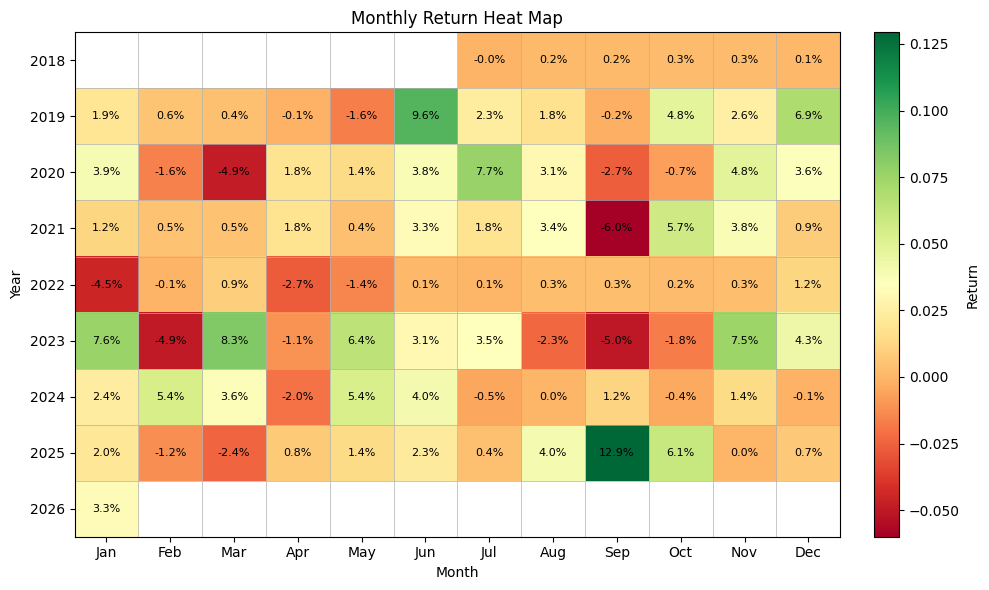

In [12]:
monthly_table, ax = plot_monthly_return_heatmap(equity_df, column="Equity")
plt.show()